### This notebook demonstrates the prediction of bathymetry by using random forest model. The data is mosaicked by taking the median of 1 yr long satellite images (from 2020/10). Assuming the water level remains the same all the year.

In [1]:
import rioxarray as rxr

In [2]:
swanson_da = rxr.open_rasterio('../data/swanson/202010_1yr_median_clipped.tif')

#### Note: the bands are changed from string to integer

In [3]:
swanson_da

<xarray.DataArray (band: 16, y: 412, x: 793)>
[5227456 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * x            (x) float64 3.165e+05 3.165e+05 ... 3.244e+05 3.244e+05
  * y            (y) float64 4.45e+06 4.45e+06 4.45e+06 ... 4.446e+06 4.446e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     stackstac-2def63b493e1413ae9abc6d4d5850467

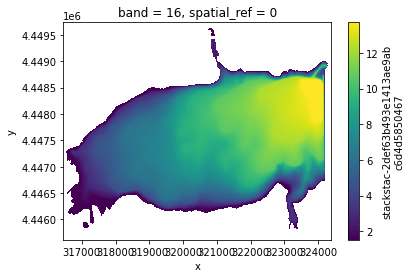

In [4]:
swanson_da.sel(band=16).plot()

In [6]:
swanson_da_numpy = swanson_da.copy().to_numpy()

In [7]:
swanson_da_numpy.shape

(16, 412, 793)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [9]:
rf = RandomForestRegressor(random_state=42)

#### Shuffle the pixels the separate them into train set and test set

In [10]:
lon_indices = list(range(swanson_da_numpy.shape[1]))

In [11]:
lat_indices = list(range(swanson_da_numpy.shape[2]))

In [12]:
train_lon_indices, test_lon_indices = train_test_split(lon_indices, test_size=0.2, random_state=42)

In [13]:
train_lat_indices, test_lat_indices = train_test_split(lat_indices, test_size=0.2, random_state=42)

In [14]:
train = swanson_da_numpy[:,train_lon_indices, :]
train = train[:,:,train_lat_indices]

In [15]:
train.shape

(16, 329, 634)

In [16]:
test = swanson_da_numpy[:,test_lon_indices, :]
test = test[:,:,test_lat_indices]

In [17]:
test.shape

(16, 83, 159)

In [18]:
target_train = train[15,:,:]
target_test = test[15:,:,]

In [19]:
train_dropT = train[:15,:,:]
test_dropT = test[:15,:,:]

In [20]:
train_dropT.shape

(15, 329, 634)

In [21]:
target_train.shape

(329, 634)

#### Reshape dimension to 2D due to acceptance of input format of RF model

In [22]:
train_dropT_2D = train_dropT.reshape((train_dropT.shape[0],train_dropT.shape[1]*train_dropT.shape[2]))

In [23]:
target_train_1D = target_train.reshape(target_train.shape[0]*target_train.shape[1])

#### Turn NaN into 0

In [24]:
train_dropT_2D = np.nan_to_num(train_dropT_2D)

In [25]:
target_train_1D = np.nan_to_num(target_train_1D)

In [26]:
train_dropT_2D.transpose().shape

(208586, 15)

In [27]:
target_train_1D.shape

(208586,)

In [28]:
rf_model = rf.fit(train_dropT_2D.transpose(), target_train_1D)

In [29]:
test_dropT = test_dropT.reshape((test_dropT.shape[0],test_dropT.shape[1]*test_dropT.shape[2]))

In [30]:
test_dropT = np.nan_to_num(test_dropT)

In [43]:
prediction = rf_model.predict(test_dropT.transpose())
prediction

array([ 4.70093808,  6.81482134,  9.60904321, ..., 10.36953627,
        9.59239174,  9.72975539])

In [32]:
test_dropT.shape

(15, 13197)

In [33]:
prediction.shape

(13197,)

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
target_test.shape

(1, 83, 159)

In [36]:
target_test = target_test.reshape(target_test.shape[1]*target_test.shape[2])

In [44]:
target_test = np.nan_to_num(target_test)
target_test

array([ 4.8252019 ,  6.15383248,  7.97419216, ..., 11.35494534,
        9.21741835, 10.19332787])

#### MAE is about 0.24m.

In [45]:
mean_absolute_error(target_test, prediction)

0.24440948682783492